In [1]:
!pip install pennylane
!python -m pip install pennylane-sf
# !pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import strawberryfields as sf
import torch
import tensorflow as tf

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy


env: OMP_NUM_THREADS=1


In [3]:
np.random.seed(0)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.cuda.is_available()

True

# Dataset

In [42]:
def create_data_set(drop: float):
    np.random.seed(0)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    visualize_dataset(X, y, ValX, ValY)

    X = [torch.tensor(x) for x in X]
    ValX = [torch.tensor(x) for x in ValX]

    return X, torch.tensor(y).type(torch.float64), ValX, torch.tensor(ValY).type(torch.float64)

In [43]:
def visualize_dataset(trainX, trainY, ValX, ValY)-> None:
    colors = ['blue', 'red', 'yellow', 'green']

    for k in np.unique(trainY):
        plt.plot(trainX[trainY==k, 0], trainX[trainY==k, 1], 'o', label='class {}'.format(k), color = colors[k])

    for k in np.unique(ValY):
        plt.plot(ValX[ValY==k, 0], ValX[ValY==k, 1], 'o', label='class {}'.format(k), color = colors[k+2])

    plt.legend(loc='best')
    plt.show()
    plt.close()

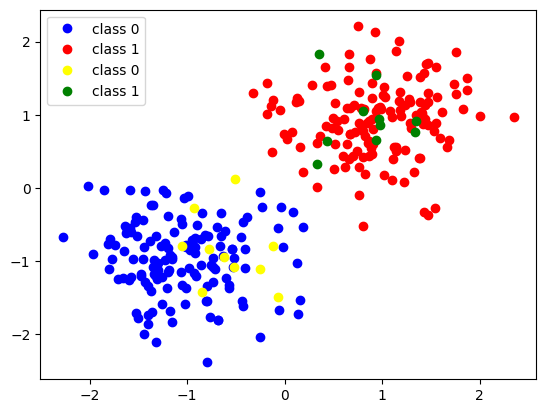

In [44]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

# Model

In [45]:
shots = 100  # кол-во измерений для набора статистики  'qulacs.simulator'  "strawberryfields.fock"
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=5, shots=shots)

In [46]:
dev

<StrawberryFieldsFock device (wires=2, shots=100) at 0x7f207b7823e0>

In [47]:
params_num = 4

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)

    qml.Rotation(params[0], wires=0)
    qml.Rotation(params[1], wires=1)
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[0, 1])
    qml.Displacement(params[2], 0.0, wires=1)
    qml.Displacement(params[3], 0.0, wires=1)
    qml.Kerr(np.pi, wires=0)
    qml.Kerr(np.pi, wires=1)


@qml.qnode(dev, interface='torch')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='torch')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params, x)
    o1 = circuit_1(params, x)
    p0 = o0/(o0+o1)
    # print(p0)
    return p0  # , 1-p0

In [48]:
# from tensorflow import keras

def square_loss(labels, predictions):
    loss = torch.sum((labels - torch.absolute(predictions)) ** 2) / labels.size(dim=0)
    # print(loss)
    return loss


def log_loss(labels, predictions):
    loss = torch.sum(labels * torch.log(predictions) + (1 - labels)*torch.log(1 - predictions))

    return loss


def accuracy(labels, predictions):
    acc = 0
    pred = torch.round(predictions)
    for l, p in zip(labels, torch.absolute(pred)):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / labels.size(dim=0)
    return acc

In [49]:
def cost(var, data_input, labels):
    predictions = torch.tensor([classifier(var, x.to(device)) for x in data_input], requires_grad=True)
    loss = torch.absolute(square_loss(labels, predictions))

    return loss

In [50]:
device

device(type='cuda', index=0)

In [55]:
import time

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

var = torch.tensor([0.5]*params_num, dtype=torch.float64, requires_grad = True)
var.to(device)
steps = 10

print(f'trainable params: {var}')

opt = torch.optim.SGD([var], lr = 0.35)
criterion = torch.nn.MSELoss(reduction='sum')  # torch.nn.BCELoss()

start_from = time.time()

for step in range(steps):

    opt.zero_grad()
    total_train_loss = 0
    total_val_loss = 0
    train_accuracy = 0
    val_accuracy = 0

    for idx, (x, y) in enumerate(zip(trainX, trainY)):
        # (x, y) = (x.to(device), y.to(device))
        prediction = classifier(var, x) # .requires_grad_(True)
        train_loss = criterion(torch.round(prediction), y)  # torch.absolute(square_loss(trainY, predictions))

        total_train_loss += train_loss
        train_loss.backward()
        opt.step()

        if torch.round(prediction) == y:
            train_accuracy += 1

    for idx, (x, y) in enumerate(zip(ValX, ValY)):
        prediction = classifier(var, x) # .requires_grad_(True)
        val_loss = criterion(torch.round(prediction), y)  # torch.absolute(square_loss(trainY, predictions))

        total_val_loss += val_loss
        if torch.round(prediction) == y:
            val_accuracy += 1

    train_loss_history.append((total_train_loss / len(trainY)).detach().numpy())
    train_acc_history.append(train_accuracy / len(trainY))
    val_loss_history.append((total_val_loss / len(ValY)).detach().numpy())
    val_acc_history.append(val_accuracy / len(ValY))

    train_loss = total_train_loss / len(trainY)
    train_accuracy = train_accuracy / len(trainY)
    val_loss = total_val_loss / len(ValY)
    val_accuracy = val_accuracy / len(ValY)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.5f} | Train accuracy: {train_accuracy:0.3f} | Val Loss: {val_loss:0.5f} | Val_accuracy: {val_accuracy:0.3f} ")

print(f'ended: {time.time() - start_from}')

trainable params: tensor([0.5000, 0.5000, 0.5000, 0.5000], dtype=torch.float64,
       requires_grad=True)


/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.


Iter:     1 | Train Loss: 0.82500 | Train accuracy: 0.871 | Val Loss: 0.15000 | Val_accuracy: 0.850 
Iter:     2 | Train Loss: 0.20714 | Train accuracy: 0.875 | Val Loss: 0.10000 | Val_accuracy: 0.900 
Iter:     3 | Train Loss: 0.23214 | Train accuracy: 0.893 | Val Loss: 0.10000 | Val_accuracy: 0.900 
Iter:     4 | Train Loss: 0.78214 | Train accuracy: 0.879 | Val Loss: 0.10000 | Val_accuracy: 0.900 
Iter:     5 | Train Loss: 0.45357 | Train accuracy: 0.854 | Val Loss: 12.05000 | Val_accuracy: 0.900 
Iter:     6 | Train Loss: 0.33929 | Train accuracy: 0.861 | Val Loss: 0.05000 | Val_accuracy: 0.950 
Iter:     7 | Train Loss: 0.22500 | Train accuracy: 0.871 | Val Loss: 0.15000 | Val_accuracy: 0.850 
Iter:     8 | Train Loss: 3.85714 | Train accuracy: 0.854 | Val Loss: 0.10000 | Val_accuracy: 0.900 
Iter:     9 | Train Loss: 0.50000 | Train accuracy: 0.832 | Val Loss: 0.05000 | Val_accuracy: 0.950 
Iter:    10 | Train Loss: 0.17500 | Train accuracy: 0.864 | Val Loss: 0.05000 | Val_accura

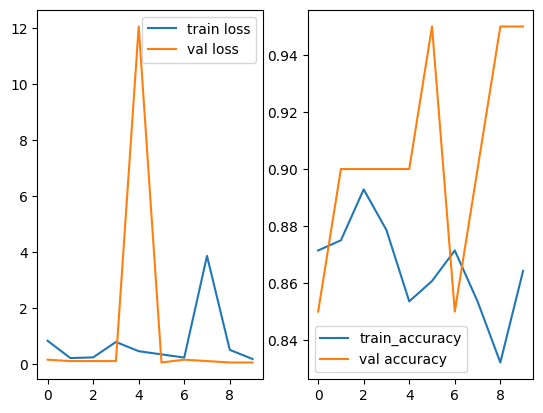

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(train_loss_history, label='train loss')
axs[0].plot(val_loss_history, label='val loss')
# axs[0].
axs[0].legend()

axs[1].plot(train_acc_history, label='train_accuracy')
axs[1].plot(val_acc_history, label='val accuracy')
axs[1].legend()

plt.show()

In [15]:
trainX.size(dim=0)

280

# Kak TorchLayer

In [ ]:
params_num = 4

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)

    qml.Rotation(params[0], wires=0)
    qml.Rotation(params[1], wires=1)
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[0, 1])
    qml.Displacement(params[2], 0.0, wires=1)
    qml.Displacement(params[3], 0.0, wires=1)
    qml.Kerr(np.pi, wires=0)
    qml.Kerr(np.pi, wires=1)


@qml.qnode(dev, interface='torch')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='torch')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([0,2], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='torch')
def classifier(var, x):

    def circuit_0(var, sample):
        layer(var, sample)
        return qml.expval(op=qml.FockStateProjector(np.array([2,0], requires_grad=False), wires=[0,1]))

    def circuit_1(var, sample):
        layer(var, sample)
        return qml.expval(op=qml.FockStateProjector(np.array([0,2], requires_grad=False), wires=[0,1]))
    # print(x)
    o0 = circuit_0(var, x)
    o1 = circuit_1(var, x)
    p0 = o0/(o0+o1)
    # print(p0)
    return p0  # , 1-p0

In [ ]:
var = torch.tensor([0.5]*params_num, requires_grad=True)
weight_shapes = {"var": params_num}

qlayer = qml.qnn.TorchLayer(classifier, weight_shapes)
model = torch.nn.Sequential(qlayer)

opt = torch.optim.SGD(model.parameters(), lr=0.5)
loss = torch.nn.MSELoss()

epochs = 8
batch_size = 5
batches = trainX.size(dim=0) // batch_size

data_loader = torch.utils.data.DataLoader(list(zip(trainX, trainY)), batch_size=batch_size,
                                          shuffle=True, drop_last=True)

for epoch in range(epochs):

    running_loss = 0

    for x, y in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

#with Tensorflow

In [ ]:
def create_data_set(drop: float):
    np.random.seed(0)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    visualize_dataset(X, y, ValX, ValY)

    return tf.constant(X), tf.constant(y), tf.constant(ValX), tf.constant(ValY)

In [ ]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

In [ ]:
shots = 100  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=5, shots=shots)

In [ ]:
params_num = 8

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)

    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    # qml.Rotation(params[2], wires=0)
    # qml.Rotation(params[3], wires=1)
    qml.Displacement(params[2], 0.0, wires=0)
    qml.Displacement(params[3], 0.0, wires=1)
    qml.QuadraticPhase(params[4], wires=0)
    qml.QuadraticPhase(params[5], wires=0)
    qml.Kerr(params[6], wires=0)
    qml.Kerr(params[7], wires=1)


@qml.qnode(dev, interface='tf')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='tf')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params,x)
    o1 = circuit_1(params,x)
    p0 = o0/(o0+o1)
    return p0  # , 1-p0

In [ ]:
n_wires = 20
n_layers = 10

dev = qml.device('default.qubit', wires=n_wires)

params_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
params = torch.rand(params_shape)

@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_cuda(params):
    qml.StronglyEntanglingLayers(params, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))

In [ ]:
import timeit
timeit.timeit("circuit_cuda(params)", globals=globals(), number=5)

In [ ]:
params = params.to(device=torch.device('cuda'))
timeit.timeit("circuit_cuda(params)", globals=globals(), number=5)